# Brain Tumor Classifier

## Import modules

In [15]:
from model.model_v1 import *
from utils.dataset_loader import *
from utils.loss_tracker import *
from utils.plot_utils import *

from torchvision.transforms import v2
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import os

## Setup

In [6]:
# Dataset dir path.
DATASET_DIR = "./data"

# Log dir path.
#LOG_DIR = "./lightning_logs/version_12/checkpoints/"

In [7]:
# Define input the image size (network input).
IMAGE_SIZE = 224

# Define train set and test set transformations.
train_transform = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),                    
    v2.RandomHorizontalFlip(p=0.1),                           
    v2.RandomRotation(degrees=1),                             
    #v2.RandomAffine(degrees=0, scale=(0.9, 1.1)),              
    #v2.ToDtype(torch.float32, scale=True),                    
    #v2.Normalize(mean=[0.485, 0.456, 0.406],                  
    #             std=[0.229, 0.224, 0.225]),
    v2.ToTensor(), 
    v2.ToDtype(torch.float32, scale=True)
])

test_transform = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),                    
    v2.ToTensor(), 
    v2.ToDtype(torch.float32, scale=True)
])

# Define the datamodule.
brisc_dm = BRISCDataModule(
    data_dir=DATASET_DIR,
    batch_size=128,
    train_transform=train_transform,
    test_transform=test_transform,
    num_workers=9
)

C:\Users\kriptos\miniconda3\envs\jupyter_env\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Plot dataset information

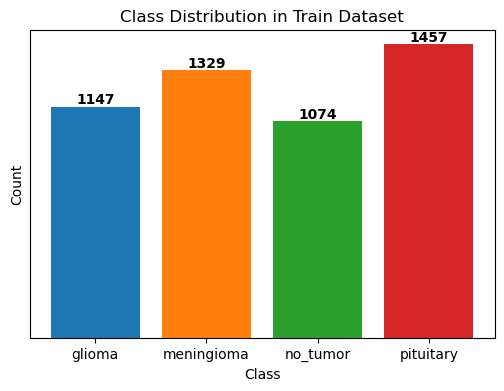

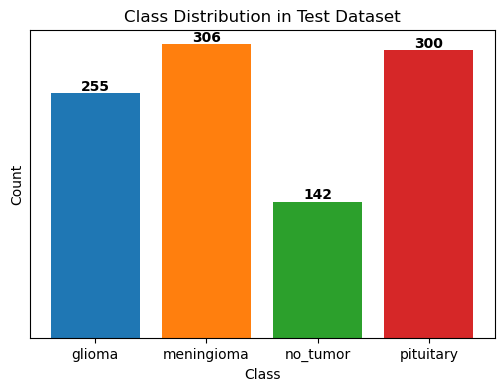

In [8]:
plot_distribution(DATASET_DIR, "Train")
plot_distribution(DATASET_DIR, "Test")

## Define the model

In [9]:
model = ResNetFineTuner(num_classes=4, lr=1e-4, freeze_backbone=True)

C:\Users\kriptos\miniconda3\envs\jupyter_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kriptos\miniconda3\envs\jupyter_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train model

In [9]:
# Define the loss tracker callback.
loss_tracker = LossTracker()

# Define the early stopping callback.
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5
)

# Define the checkpoint callback.
# (Used to save the model with the lowest
# validation loss).
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    verbose=True
)

# Define the trainer.
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    callbacks=[loss_tracker, early_stopping, checkpoint_callback],
    enable_progress_bar=False
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\kriptos\miniconda3\envs\jupyter_env\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [10]:

# Train model.
trainer.fit(model, brisc_dm)
# Plot losses.
loss_tracker.plot()

NameError: name 'trainer' is not defined

## Fine tuning the model

In [11]:
#ckpt_path = [f for f in os.listdir(LOG_DIR)][0]
#ckpt_path = os.path.join(LOG_DIR, ckpt_path)
#print(ckpt_path)

In [12]:
# Load best model.
model = ResNetFineTuner.load_from_checkpoint("good/checkpoints/best-checkpoint-epoch=29-val_loss=0.37.ckpt")

# Unfreeze backbone.
for param in model.parameters():
    param.requires_grad = True

# Reset plots.
loss_tracker.train_loss = []
loss_tracker.train_acc = []
loss_tracker.val_loss = []
loss_tracker.val_acc = []

# Re-define the trainer.
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=15,
    callbacks=[loss_tracker, early_stopping, checkpoint_callback],
    enable_progress_bar=False
)

# Re-start training.
trainer.fit(model, brisc_dm)
# Plot losses.
loss_tracker.plot()

NameError: name 'loss_tracker' is not defined

In [13]:
# Load the best model (after fine tuning).
model = ResNetFineTuner.load_from_checkpoint("good/checkpoints/best-checkpoint-epoch=29-val_loss=0.37.ckpt")

# Test model.
trainer.test(model, brisc_dm)

NameError: name 'trainer' is not defined

In [16]:
# Plot final statistics.

# Plot confusion matrix.
plot_confusion_matrix(brisc_dm, model)

# Plot various statistics of the results.
plot_statistics(cm)

TypeError: plot_confusion_matrix() takes 0 positional arguments but 2 were given